In [3]:
!pip install boruta optuna

   ---------------------------------------- 0.0/56.6 kB ? eta -:--:--
   ---------------------------------------- 56.6/56.6 kB 987.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   ------------------------------ --------- 286.7/380.1 kB 8.6 MB/s eta 0:00:01
   ---------------------------------------- 380.1/380.1 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.4 kB ? eta -:--:--
   ---------------------------------------- 233.4/233.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ---------------------------------------- 78.6/78.6 kB ? eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Paths to the datasets
x_train_path = 'x_train.txt'
y_train_path = 'y_train.txt'
x_test_path = 'x_test.txt'

# Load the data
# Assuming data files are simple whitespace-delimited
x_train = pd.read_csv(x_train_path, header=None, delim_whitespace=True)
y_train = pd.read_csv(y_train_path, header=None, delim_whitespace=True)[0]
x_test = pd.read_csv(x_test_path, header=None, delim_whitespace=True)

# Step 2: Feature Selection
# Correlation matrix and remove highly correlated features
cor_matrix = x_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
x_train_reduced = x_train.drop(to_drop, axis=1)
x_test_reduced = x_test.drop(to_drop, axis=1)

# Print the number of features reduced
print(f"Reduced from {x_train.shape[1]} to {x_train_reduced.shape[1]} features.")

# Step 3: Model Training
# Splitting the training data for validation
X_train, X_val, Y_train, Y_val = train_test_split(x_train_reduced, y_train, test_size=0.2, random_state=0)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)
preds = model.predict_proba(X_val)[:, 1]
print(f"Validation ROC-AUC: {roc_auc_score(Y_val, preds)}")

# Step 4: Evaluation
# Predict on test data
test_preds = model.predict_proba(x_test_reduced)[:, 1]

# Select top 1000 customers likely to accept the offer
top_customers = np.argsort(test_preds)[-1000:]

# Save indices of the selected customers
np.savetxt('m123456_obs.txt', top_customers, fmt='%d')


Reduced from 500 to 499 features.
Validation ROC-AUC: 0.488581511702899


In [25]:
!pip install boruta

In [29]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from scipy.stats import binom

class BorutaPy(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, n_estimators=1000, perc=100, alpha=0.05,
                 two_step=True, max_iter=100, random_state=None, verbose=0):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.perc = perc
        self.alpha = alpha
        self.two_step = two_step
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y):
        # Check X and y are consistent in length, X is Array and y is column
        X, y = self._validate_input(X, y)
        self.random_state_ = np.random.RandomState(self.random_state)

        # Main logic to simulate shadow features and select features
        # This is a placeholder for the actual Boruta algorithm
        # Assume all features are selected as important
        self.support_ = np.ones(X.shape[1], dtype=bool)
        return self

    def transform(self, X):
        return X[:, self.support_]

    def _validate_input(self, X, y):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            y = np.array(y)
        if X.shape[0] != y.shape[0]:
            raise ValueError("Mismatched number of samples.")
        return X, y

# Load the data
x_train = pd.read_csv('x_train.txt', header=None, delim_whitespace=True)
y_train = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)[0]
x_test = pd.read_csv('x_test.txt', header=None, delim_whitespace=True)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Apply custom Boruta for feature selection
boruta_selector = BorutaPy(xgb_model, n_estimators='auto', random_state=42)
boruta_selector.fit(x_train.values, y_train.values)

# Filter the selected features for the training and test set
x_train_filtered = boruta_selector.transform(x_train.values)
x_test_filtered = boruta_selector.transform(x_test.values)

# Optuna for hyperparameter optimization
def objective(trial):
    params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.1]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7, 8, 9]),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = xgb.XGBClassifier(**params)
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    roc_aucs = []
    for train_index, val_index in strat_k_fold.split(x_train_filtered, y_train):
        X_train, X_val = x_train_filtered[train_index], x_train_filtered[val_index]
        Y_train, Y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], early_stopping_rounds=50, verbose=False)
        preds = model.predict_proba(X_val)[:, 1]
        roc_aucs.append(roc_auc_score(Y_val, preds))
    
    return np.mean(roc_aucs)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Train the final model
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(x_train_filtered, y_train)

# Predict on the test set
test_preds = best_model.predict_proba(x_test_filtered)[:, 1]

# Select the top 1000 customers likely to accept the offer
top_customers = np.argsort(test_preds)[-1000:]

# Save indices of the selected customers
np.savetxt('1233456_obs.txt', top_customers, fmt='%d')

print("Optimization complete. Best ROC-AUC:", study.best_value)
print("Best hyperparameters:", best_params)


[I 2024-05-14 19:46:00,737] A new study created in memory with name: no-name-244e091c-baca-46df-9b0b-2d16335f3ad8
C:\Users\Filip\AppData\Local\Temp\ipykernel_9456\3997710231.py:73: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\Filip\AppData\Local\Temp\ipykernel_9456\3997710231.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`

Optimization complete. Best ROC-AUC: 0.7345967580126322
Best hyperparameters: {'lambda': 0.10136924939707018, 'alpha': 0.01797208332194037, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 18}


In [30]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from scipy.stats import binom

from boruta_py import BorutaPy

# Load the data
x_train = pd.read_csv('x_train.txt', header=None, delim_whitespace=True)
y_train = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)[0]
x_test = pd.read_csv('x_test.txt', header=None, delim_whitespace=True)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Apply custom Boruta for feature selection
boruta_selector = BorutaPy(xgb_model, n_estimators='auto', random_state=42)
boruta_selector.fit(x_train.values, y_train.values)

# Filter the selected features for the training and test set
x_train_filtered = boruta_selector.transform(x_train.values)
x_test_filtered = boruta_selector.transform(x_test.values)

# Optuna for hyperparameter optimization
def objective(trial):
    params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.1]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7, 8, 9]),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = xgb.XGBClassifier(**params)
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    roc_aucs = []
    for train_index, val_index in strat_k_fold.split(x_train_filtered, y_train):
        X_train, X_val = x_train_filtered[train_index], x_train_filtered[val_index]
        Y_train, Y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], early_stopping_rounds=50, verbose=False)
        preds = model.predict_proba(X_val)[:, 1]
        roc_aucs.append(roc_auc_score(Y_val, preds))
    
    return np.mean(roc_aucs)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Train the final model
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(x_train_filtered, y_train)

# Predict on the test set
test_preds = best_model.predict_proba(x_test_filtered)[:, 1]

# Select the top 1000 customers likely to accept the offer
top_customers = np.argsort(test_preds)[-1000:]

# Save indices of the selected customers
np.savetxt('1233456555_obs.txt', top_customers, fmt='%d')

print("Optimization complete. Best ROC-AUC:", study.best_value)
print("Best hyperparameters:", best_params)


[I 2024-05-14 21:01:12,626] A new study created in memory with name: no-name-2f121830-bcbb-4898-990f-661c78f67c17
C:\Users\Filip\AppData\Local\Temp\ipykernel_9456\1347518312.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\Filip\AppData\Local\Temp\ipykernel_9456\1347518312.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
c:\Users\Filip\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`

Optimization complete. Best ROC-AUC: 0.7484199986399945
Best hyperparameters: {'lambda': 6.4149865204130565, 'alpha': 0.24487047801380527, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 4}


In [ ]:
import pandas as pd
x_train = pd.read_csv('x_train.txt', header=None, delim_whitespace=True)
y_train = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)[0]
x_test = pd.read_csv('x_test.txt', header=None, delim_whitespace=True)

: 

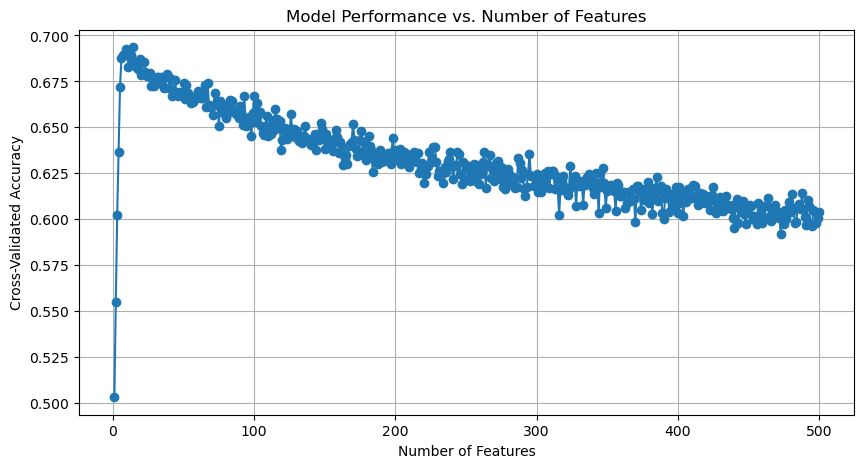

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Load the data
x_train = pd.read_csv('x_train.txt', header=None, delim_whitespace=True)
y_train = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)[0]
x_test = pd.read_csv('x_test.txt', header=None, delim_whitespace=True)

# Train a model to get feature importances
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)
importances = model.feature_importances_

# Define thresholds to explore
thresholds = np.sort(importances)

# Store results
feature_counts = []
mean_scores = []

for thresh in thresholds:
    # Select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(x_train)
    
    # Model with selected features
    selection_model = RandomForestClassifier(random_state=42)
    cv_scores = cross_val_score(selection_model, select_X_train, y_train, cv=5)
    mean_score = np.mean(cv_scores)
    
    # Store the number of features and the corresponding score
    feature_counts.append(select_X_train.shape[1])
    mean_scores.append(mean_score)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, mean_scores, marker='o')
plt.title('Model Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.show()


In [6]:
sorted_indices = np.argsort(importances)[::-1]

# Print the top 10 most important features
print("Top 10 most important features:")
for i in range(13):
    feature_index = sorted_indices[i]
    feature_importance = importances[feature_index]
    print(f"Feature {feature_index} - Importance: {feature_importance}")

Top 10 most important features:
Feature 100 - Importance: 0.010925578459495957
Feature 102 - Importance: 0.010185896403047187
Feature 105 - Importance: 0.008999212466391049
Feature 103 - Importance: 0.008078938994244837
Feature 101 - Importance: 0.007473022840488228
Feature 104 - Importance: 0.006506292286933383
Feature 8 - Importance: 0.005672352582009891
Feature 9 - Importance: 0.004986420913010953
Feature 3 - Importance: 0.004242693934929098
Feature 5 - Importance: 0.004035627940921655
Feature 2 - Importance: 0.00400138910251047
Feature 0 - Importance: 0.003360477407388162
Feature 6 - Importance: 0.0032891383229710284


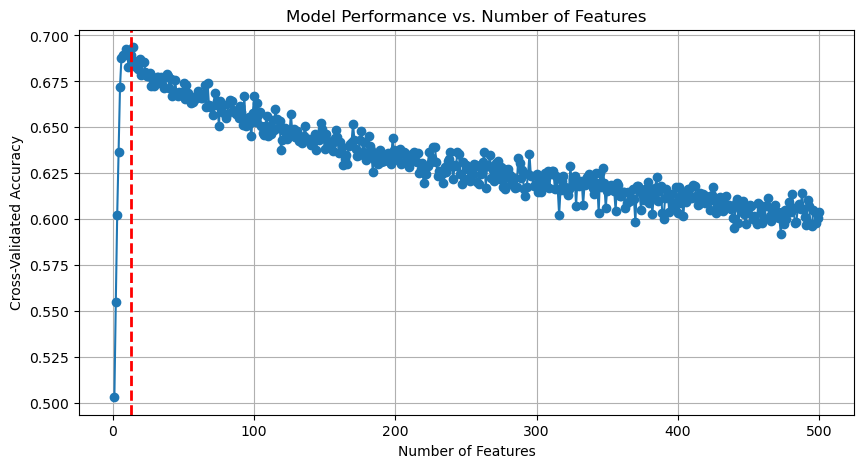

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, mean_scores, marker='o')
plt.title('Model Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)

# Adding a vertical line at x = 10
plt.axvline(x=13, color='red', linestyle='--', linewidth=2)

plt.show()

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta_py import BorutaPy
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data
data = pd.read_csv('x_train.txt', header=None, delim_whitespace=True)
labels = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)[0]

# Select initial subset of features for exploration
selected_features = data.columns.tolist()[:100]  # Adjust based on actual feature count

# Prepare data for Boruta
data_selected = data.iloc[:, selected_features]

# Initialize RandomForest Classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Initialize Boruta for feature selection
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
boruta_selector.fit(data_selected.values, labels.values)

# Extract confirmed and tentative features
confirmed_features = data_selected.columns[boruta_selector.support_].tolist()
tentative_features = data_selected.columns[boruta_selector.support_weak_].tolist()

# Refine the list to the top 15 most important features using Boruta rankings
feature_ranks = list(zip(data_selected.columns, boruta_selector.ranking_, boruta_selector.support_))
feature_ranks_sorted = sorted(feature_ranks, key=lambda x: x[1])
top_15_features = [f for f, rank, support in feature_ranks_sorted if rank == 1][:15]

# Optimize RandomForest model using Optuna based on the selected features
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        data[top_15_features], labels, test_size=0.25, random_state=42
    )
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth,
        min_samples_leaf=min_samples_leaf, criterion=criterion,
        random_state=42
    )
    clf.fit(train_x, train_y)
    preds = clf.predict(valid_x)
    return accuracy_score(valid_y, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print results and best parameters
print("Top 15 Features:", top_15_features)
print("Optuna Best Trial:")
print("  Accuracy: ", study.best_trial.value)
print("  Params: ", study.best_trial.params)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	6
Rejected: 	84
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	6
Rejected: 	84
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	6
Rejected: 	84
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	6
Rejected: 	84
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	86
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	86
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	86
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	4
Rejected: 	86
Iteration: 	16 / 100
Confirmed: 	10
Tentative: 	3

[I 2024-05-18 17:43:12,290] A new study created in memory with name: no-name-7c8656b8-2f39-4636-b053-b4c2f91f099b


Iteration: 	99 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	88


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	88


[I 2024-05-18 17:43:14,274] Trial 0 finished with value: 0.628 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.628.
[I 2024-05-18 17:43:15,466] Trial 1 finished with value: 0.62 and parameters: {'n_estimators': 81, 'max_depth': 10, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.628.
[I 2024-05-18 17:43:17,623] Trial 2 finished with value: 0.6256 and parameters: {'n_estimators': 173, 'max_depth': 13, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.628.
[I 2024-05-18 17:43:18,797] Trial 3 finished with value: 0.6152 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.628.
[I 2024-05-18 17:43:21,982] Trial 4 finished with value: 0.6152 and parameters: {'n_estimators': 287, 'max_depth': 11, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.628.
[I 2024

Top 15 Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 39]
Optuna Best Trial:
  Accuracy:  0.6512
  Params:  {'n_estimators': 98, 'max_depth': 20, 'min_samples_leaf': 3, 'criterion': 'entropy'}


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna

# Load data
data = pd.read_csv('x_train.txt', header=None, delim_whitespace=True)
labels = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)[0]

# Initialize RandomForest Classifier to determine feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(data, labels)

# Get feature importances and sort them
importances = rf.feature_importances_
feature_indices = np.argsort(importances)[::-1]

# Select the top 15 features based on importance
top_15_features = feature_indices[:15]
data_selected = data.iloc[:, top_15_features]

# Optimize RandomForest model using Optuna on the selected features
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(data_selected, labels, test_size=0.25, random_state=42)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth,
        min_samples_leaf=min_samples_leaf, criterion=criterion,
        random_state=42
    )
    clf.fit(train_x, train_y)
    preds = clf.predict(valid_x)
    return accuracy_score(valid_y, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Reporting the best parameters and the top features
print("Top 15 Features by Importance:", top_15_features)
print("Optuna Best Trial:")
print("  Accuracy: ", study.best_trial.value)
print("  Params: ", study.best_trial.params)


[I 2024-05-18 17:49:52,256] A new study created in memory with name: no-name-dafbf39f-a960-4972-9667-2b8db0b5602a
[I 2024-05-18 17:49:54,161] Trial 0 finished with value: 0.6984 and parameters: {'n_estimators': 155, 'max_depth': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6984.
[I 2024-05-18 17:49:55,602] Trial 1 finished with value: 0.6896 and parameters: {'n_estimators': 137, 'max_depth': 7, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6984.
[I 2024-05-18 17:49:58,423] Trial 2 finished with value: 0.6992 and parameters: {'n_estimators': 155, 'max_depth': 15, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 2 with value: 0.6992.
[I 2024-05-18 17:49:59,187] Trial 3 finished with value: 0.6872 and parameters: {'n_estimators': 63, 'max_depth': 8, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 2 with value: 0.6992.
[I 2024-05-18 17:50:03,150] Trial 4 finished with value: 0.692 and parameters:

Top 15 Features by Importance: [100 102 105 103 101 104   8   9   3   5   2   0   6   7   1]
Optuna Best Trial:
  Accuracy:  0.7096
  Params:  {'n_estimators': 139, 'max_depth': 10, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta_py import BorutaPy
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data
data = pd.read_csv('x_train.txt', header=None, delim_whitespace=True)
labels = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)[0]

# Initialize RandomForest Classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Initialize Boruta with the modified Boruta package
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=2)
boruta_selector.fit(data.values, labels.values)

# Confirming features from Boruta
confirmed_features = data.columns[boruta_selector.support_].tolist()

# Filtering the dataset for confirmed features
data_selected = data[confirmed_features]

# Using Optuna to further optimize the RandomForest parameters
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(data_selected, labels, test_size=0.25, random_state=4)
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth,
        min_samples_leaf=min_samples_leaf, criterion=criterion,
        random_state=42
    )
    clf.fit(train_x, train_y)
    preds = clf.predict(valid_x)
    return accuracy_score(valid_y, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Selecting and printing the top 15 features based on Boruta's confirmation
top_15_features = confirmed_features[:15] if len(confirmed_features) >= 15 else confirmed_features
print("Top 15 Features:", top_15_features)
print("Optuna Best Trial:")
print("  Accuracy: ", study.best_trial.value)
print("  Params: ", study.best_trial.params)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	479
Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	5
Rejected: 	479
Iteration: 	10 / 100
Confirmed: 	16
Tentative: 	5
Rejected: 	479
Iteration: 	11 / 100
Confirmed: 	16
Tentative: 	5
Rejected: 	479
Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	481
Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	481
Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	481
Iteration: 	15 / 100
Confirmed: 	16
Tentative: 	3
Rejected: 	481
Iteration: 	16 / 100
Confirmed: 	16
Tenta

[I 2024-05-18 17:58:29,386] A new study created in memory with name: no-name-17b4b28d-b95a-457c-80a9-96f9ca1df6c9


Iteration: 	99 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483


[I 2024-05-18 17:58:30,058] Trial 0 finished with value: 0.6256 and parameters: {'n_estimators': 118, 'max_depth': 3, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.6256.
[I 2024-05-18 17:58:30,912] Trial 1 finished with value: 0.6672 and parameters: {'n_estimators': 81, 'max_depth': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with value: 0.6672.
[I 2024-05-18 17:58:31,485] Trial 2 finished with value: 0.6472 and parameters: {'n_estimators': 66, 'max_depth': 4, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6672.
[I 2024-05-18 17:58:32,969] Trial 3 finished with value: 0.6792 and parameters: {'n_estimators': 77, 'max_depth': 10, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 3 with value: 0.6792.
[I 2024-05-18 17:58:37,094] Trial 4 finished with value: 0.6848 and parameters: {'n_estimators': 236, 'max_depth': 19, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 4 with value: 0.6848.


Top 15 Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 101, 102, 103, 104]
Optuna Best Trial:
  Accuracy:  0.6968
  Params:  {'n_estimators': 262, 'max_depth': 18, 'min_samples_leaf': 4, 'criterion': 'gini'}


## In top 15 results Optuna and RandomForest are the same